<a href="https://colab.research.google.com/github/codesburners/GitHub/blob/main/segmentation_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class FundusDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform = transform if transform else T.Compose([
            T.Resize((512, 512)),
            T.ToTensor()
        ])
        self.mask_transform = T.Compose([
            T.Resize((512, 512)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # vessel mask is grayscale

        image = self.transform(image)
        mask = self.mask_transform(mask)

        # convert mask to binary (0 and 1)
        mask = (mask > 0.5).float()

        return image, mask

# -------------------- STEP 1: Paths --------------------
image_dir = "/content/drive/MyDrive/Fundus_project/Data/Raw/DRIVE/training/images"
mask_dir = "/content/drive/MyDrive/Fundus_project/Data/Raw/DRIVE/training/1st_manual"

train_dataset = FundusDataset(image_dir, mask_dir)
# -------------------- STEP 3: Transforms --------------------
transform = T.Compose([
    T.Resize((512, 512)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=(-10, 10)),
    T.ToTensor(),
])

# Create dataset
dataset = FundusDataset(img_dir, mask_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"Training set: {len(train_dataset)}, Validation set: {len(val_dataset)}")

# -------------------- STEP 4: U-Net Model --------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.bottom = DoubleConv(512, 1024)
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        c1 = self.down1(x); p1 = self.pool(c1)
        c2 = self.down2(p1); p2 = self.pool(c2)
        c3 = self.down3(p2); p3 = self.pool(c3)
        c4 = self.down4(p3); p4 = self.pool(c4)
        c5 = self.bottom(p4)
        u1 = self.up1(c5); c6 = self.conv1(torch.cat([u1, c4], dim=1))
        u2 = self.up2(c6); c7 = self.conv2(torch.cat([u2, c3], dim=1))
        u3 = self.up3(c7); c8 = self.conv3(torch.cat([u3, c2], dim=1))
        u4 = self.up4(c8); c9 = self.conv4(torch.cat([u4, c1], dim=1))
        return torch.sigmoid(self.final(c9))

# -------------------- STEP 5: Loss & Metrics --------------------
def dice_loss(pred, target, smooth=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2.*intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    intersection = (pred * target).sum()
    total_area = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (total_area + smooth)

def dice_coefficient(pred, target, smooth=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    intersection = (pred * target).sum()
    return (2.*intersection + smooth) / (pred.sum() + target.sum() + smooth)

# -------------------- STEP 6: Training --------------------
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
bce_loss = nn.BCELoss()
num_epochs = 100
best_val_loss = float('inf')

print("Starting training...")
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = bce_loss(preds, masks) + 2.0 * dice_loss(preds, masks)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = val_dice = val_iou = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = bce_loss(preds, masks) + dice_loss(preds, masks)
            val_loss += loss.item()
            val_dice += dice_coefficient(preds, masks).item()
            val_iou += iou_score(preds, masks).item()
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Dice: {avg_val_dice:.4f} | "
          f"Val IoU: {avg_val_iou:.4f}")

    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_unet_model.pth")

print("Training finished. Model saved as 'best_unet_model.pth'.")


Training set: 16, Validation set: 5
Starting training...


IndexError: list index out of range

In [ ]:
# Create a new instance of the model and load the trained weights
inference_model = UNet().to(device)
inference_model.load_state_dict(torch.load("best_unet_model.pth"))
inference_model.eval() # Set the model to evaluation mode
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
# Get one image and mask from the validation dataset
# Here, we'll get the first item from the validation dataset.
sample_image, true_mask = val_dataset[0]

# Add a batch dimension to the image so it can be passed to the model
sample_image_batch = sample_image.unsqueeze(0).to(device)

In [ ]:
with torch.no_grad():
    prediction = inference_model(sample_image_batch)

# The output is a tensor, we need to convert it to a binary mask
# and move it back to the CPU for visualization
predicted_mask = (prediction.squeeze().cpu() > 0.5).float()

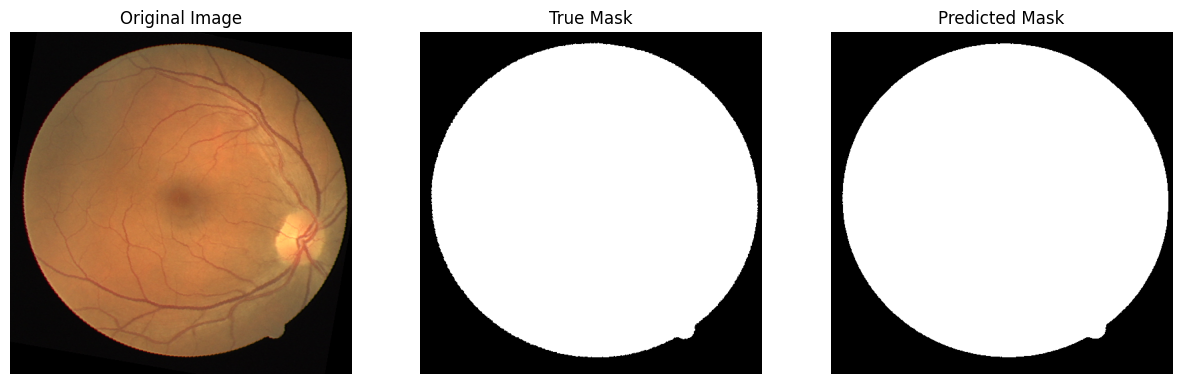

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(image, true_mask, pred_mask):
    """
    Plots the original image, true mask, and predicted mask.
    """
    # The image is a tensor, so we need to convert it back to a NumPy array for plotting
    # Permute the dimensions from (C, H, W) to (H, W, C) for matplotlib
    image_np = image.permute(1, 2, 0).numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

# Call the visualization function with the sample data
visualize_results(sample_image, true_mask, predicted_mask)

In [ ]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from tqdm import tqdm
import time
from operator import add
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import random

# =============================================================================
# --- Colab Setup ---
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')

# =============================================================================
# --- Utility Functions ---
# =============================================================================
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# =============================================================================
# --- Dataset Class ---
# =============================================================================
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = cv2.resize(image, (512, 512))
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (512, 512))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

# =============================================================================
# --- Loss Functions ---
# =============================================================================
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        return 1 - dice

class DiceBCELoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        return BCE + dice_loss

# =============================================================================
# --- U-Net Model ---
# =============================================================================
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs); x = self.bn1(x); x = self.relu(x)
        x = self.conv2(x); x = self.bn2(x); x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.conv = conv_block(out_c*2, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        self.b = conv_block(512, 1024)
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        self.outputs = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        b = self.b(p4)
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        return self.outputs(d4)

# =============================================================================
# --- Training / Evaluation ---
# =============================================================================
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    model.train()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss/len(loader)

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()
    return epoch_loss/len(loader)

# =============================================================================
# --- Main ---
# =============================================================================
if __name__ == "__main__":
    seeding(42)
    create_dir("files"); create_dir("results")
    checkpoint_path = "files/checkpoint.pth"

    # DRIVE dataset paths
    IMAGE_DIR = "/content/drive/MyDrive/Fundus_project/Data/Raw/DRIVE/training/images"
    MASK_DIR  = "/content/drive/MyDrive/Fundus_project/Data/Raw/DRIVE/training/1st_manual"

    images = sorted(glob(os.path.join(IMAGE_DIR, "*.tif")))
    masks  = sorted(glob(os.path.join(MASK_DIR, "*.gif")))

    print("Found images:", len(images))
    print("Found masks:", len(masks))
    assert len(images) == len(masks), "Mismatch between images and masks!"

    train_x, valid_x, train_y, valid_y = train_test_split(
        images, masks, test_size=0.2, random_state=42
    )
    print(f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}")

    # Hyperparameters
    batch_size = 2
    num_epochs = 50
    lr = 1e-4

    # DataLoader
    train_loader = DataLoader(DriveDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(DriveDataset(valid_x, valid_y), batch_size=batch_size, shuffle=False)

    # Model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = build_unet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
    loss_fn = DiceBCELoss()

    # Training loop
    best_valid_loss = float("inf")
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        if valid_loss < best_valid_loss:
            print(f"Valid loss improved from {best_valid_loss:.4f} to {valid_loss:.4f}. Saving checkpoint...")
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        mins, secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch+1:02} | Time: {mins}m {secs}s")
        print(f"\tTrain Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found images: 20
Found masks: 20
Dataset Size:
Train: 16 - Valid: 4
Using device: cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 640.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 118.12 MiB is free. Process 2212 has 14.62 GiB memory in use. Of the allocated memory 13.86 GiB is allocated by PyTorch, and 661.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Image 1: pred min=0.0427, max=0.9999


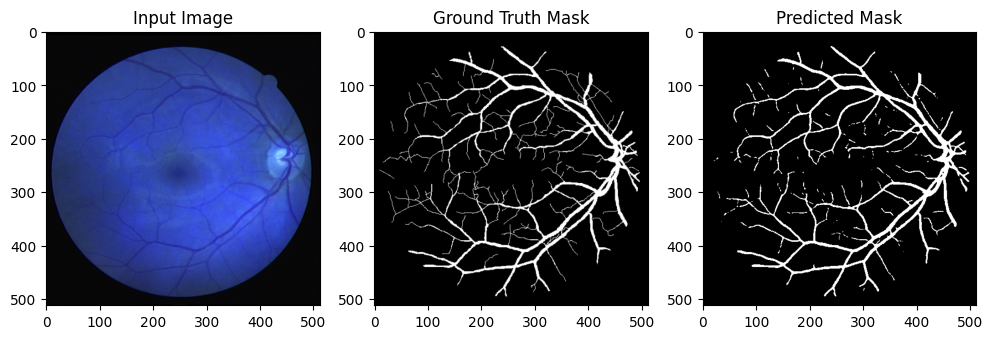

Image 2: pred min=0.0432, max=0.9999


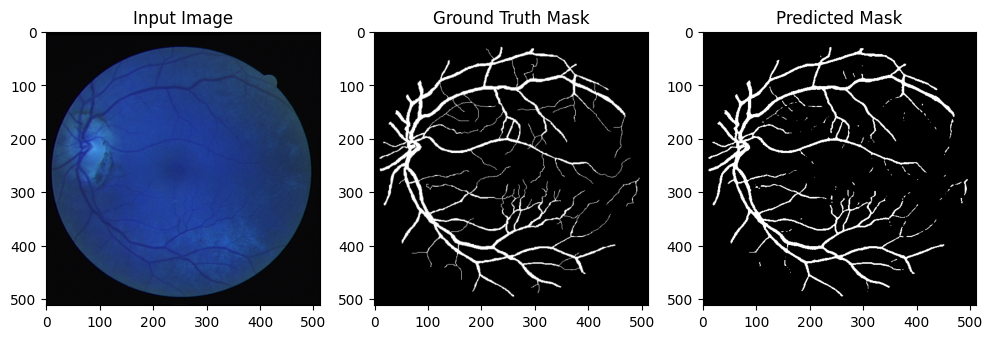

Image 3: pred min=0.0395, max=1.0000


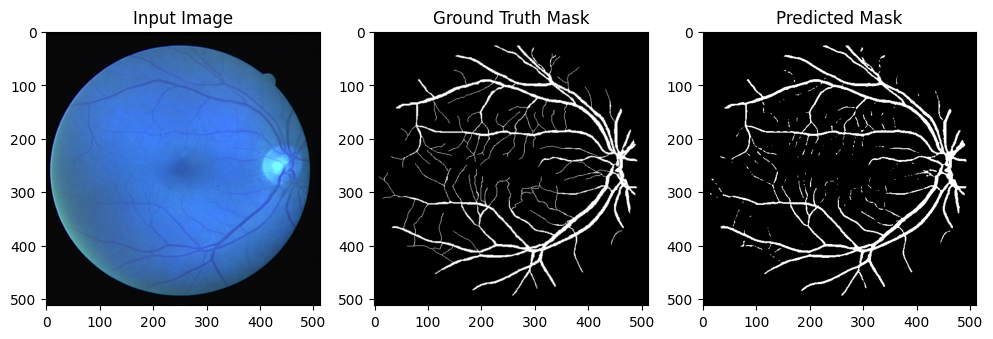

Image 4: pred min=0.0351, max=1.0000


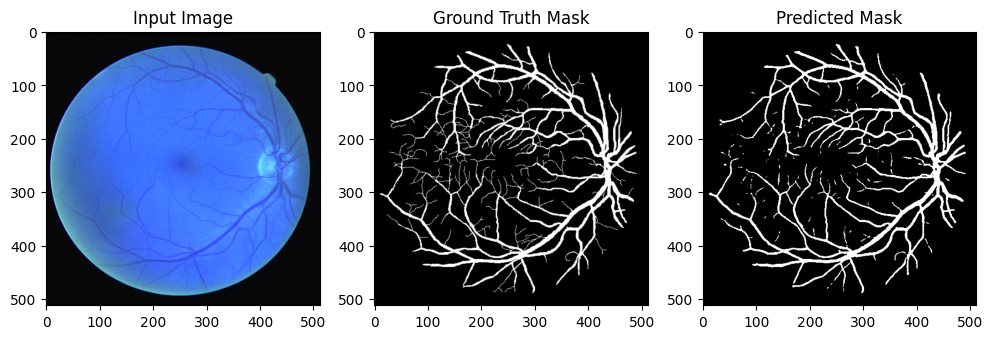

Image 5: pred min=0.0382, max=0.9999


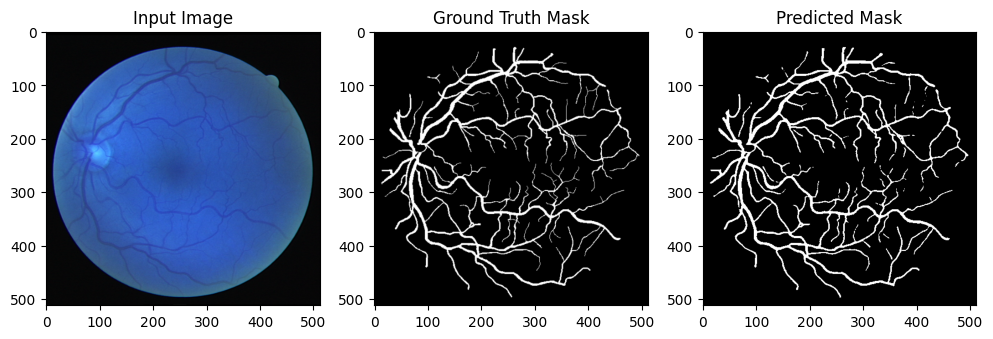

Image 6: pred min=0.0377, max=1.0000


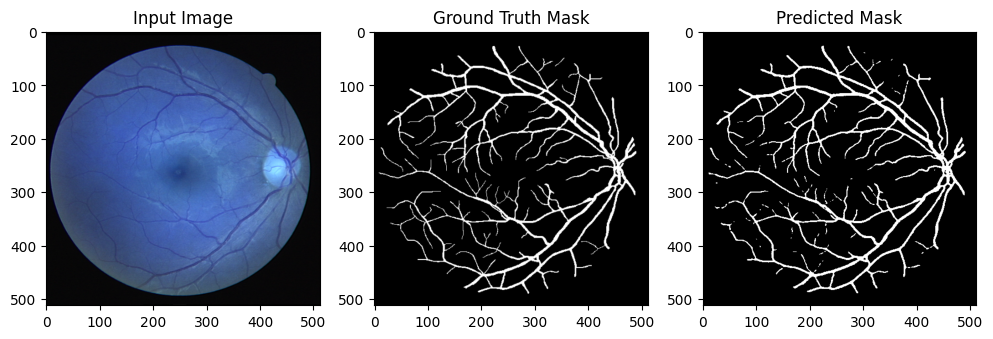

Image 7: pred min=0.0308, max=0.9999


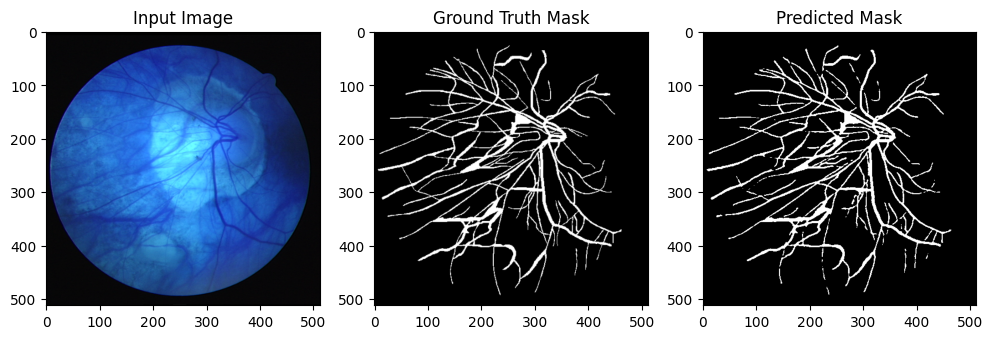

Image 8: pred min=0.0460, max=1.0000


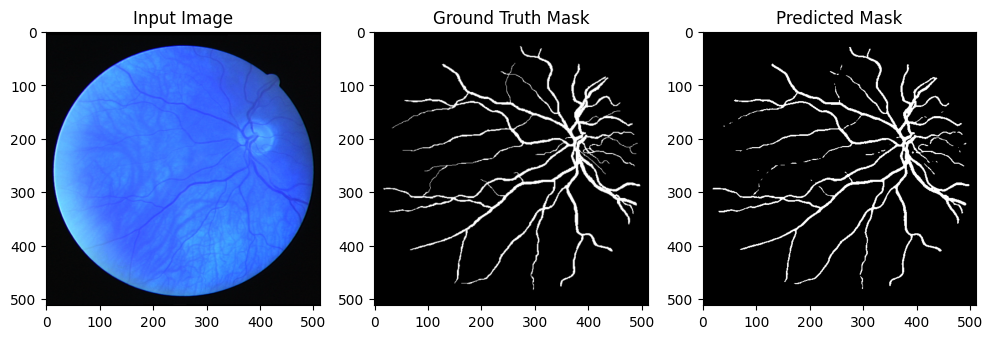

Image 9: pred min=0.0404, max=0.9999


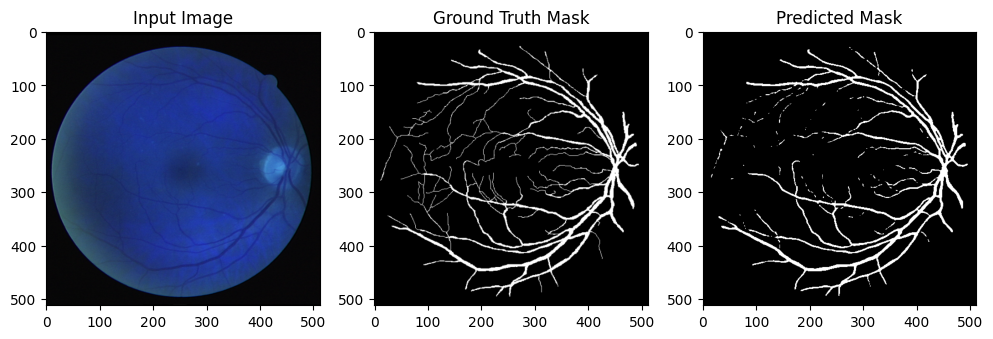

Image 10: pred min=0.0355, max=1.0000


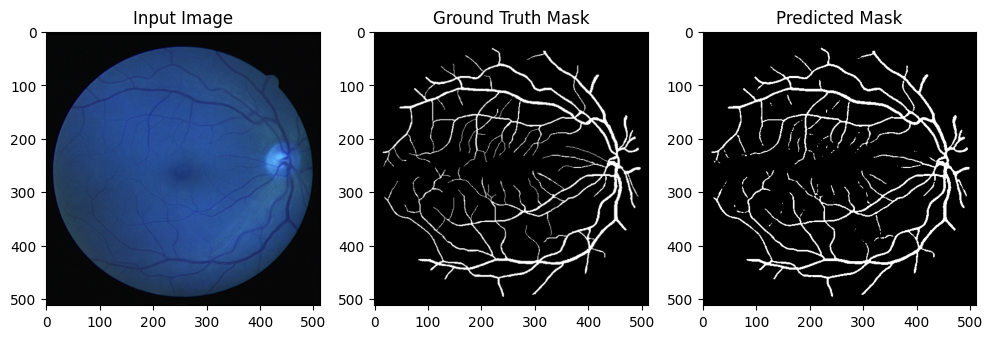

Image 11: pred min=0.0355, max=1.0000


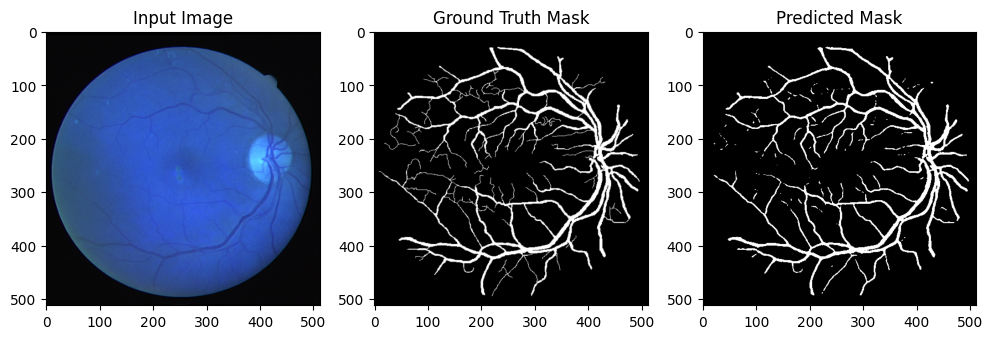

Image 12: pred min=0.0339, max=1.0000


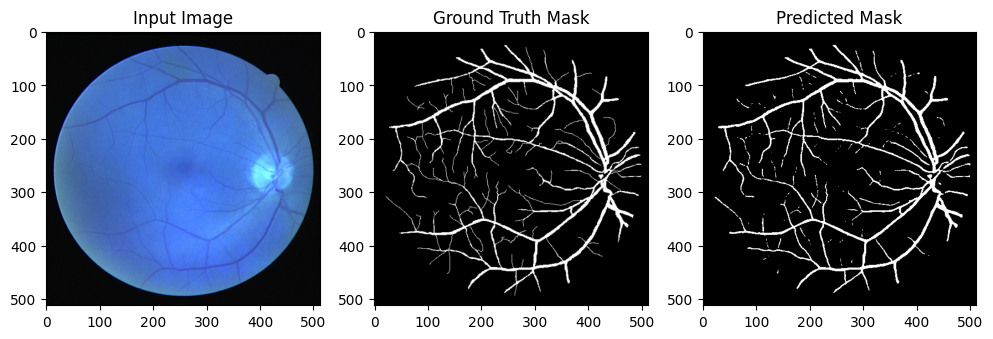

Image 13: pred min=0.0273, max=1.0000


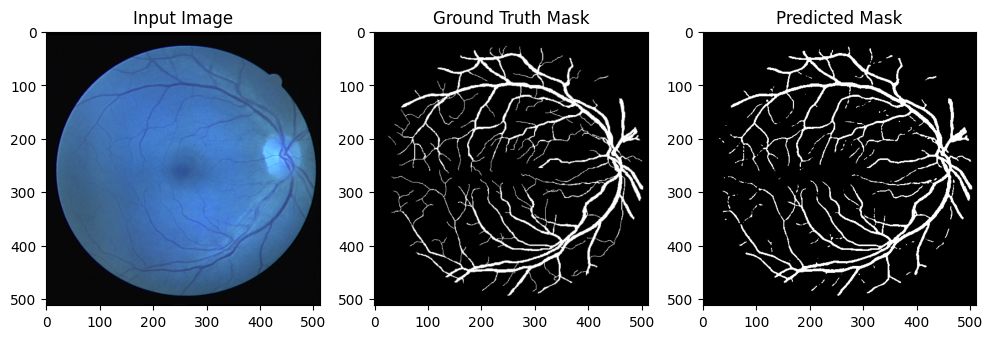

Image 14: pred min=0.0260, max=1.0000


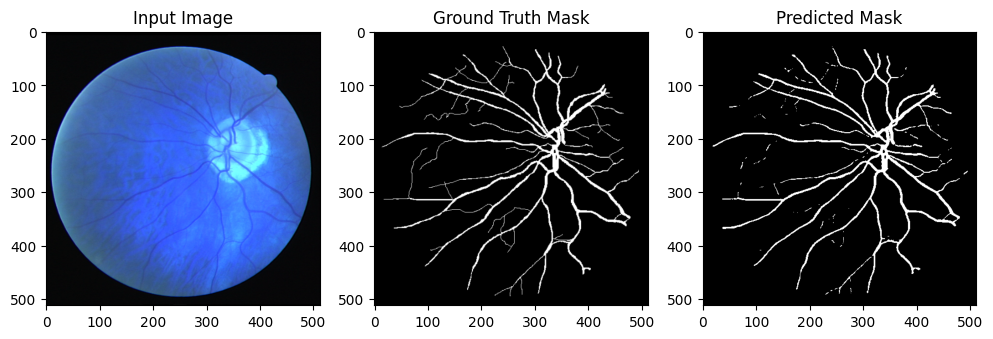

Image 15: pred min=0.0321, max=0.9999


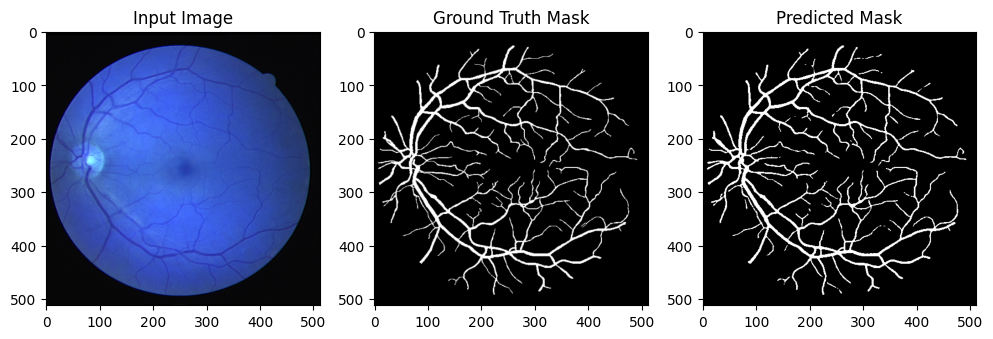

Image 16: pred min=0.0267, max=1.0000


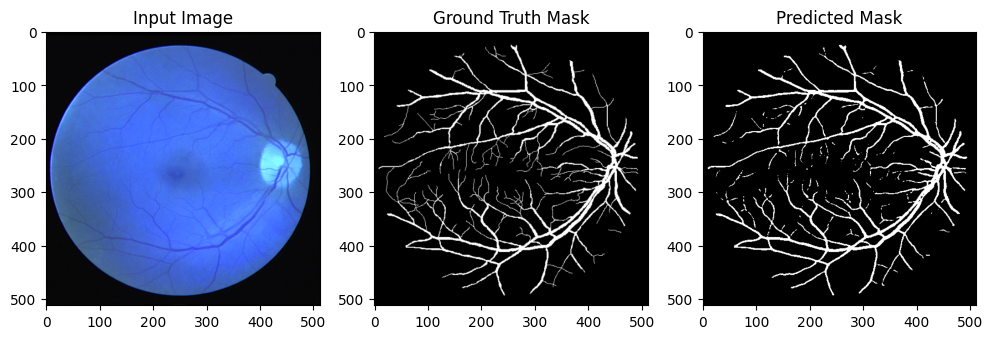

Image 17: pred min=0.0302, max=1.0000


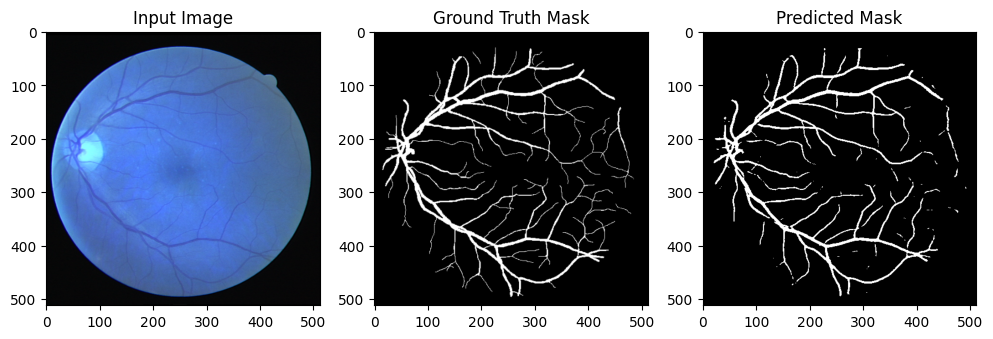

Image 18: pred min=0.0303, max=0.9999


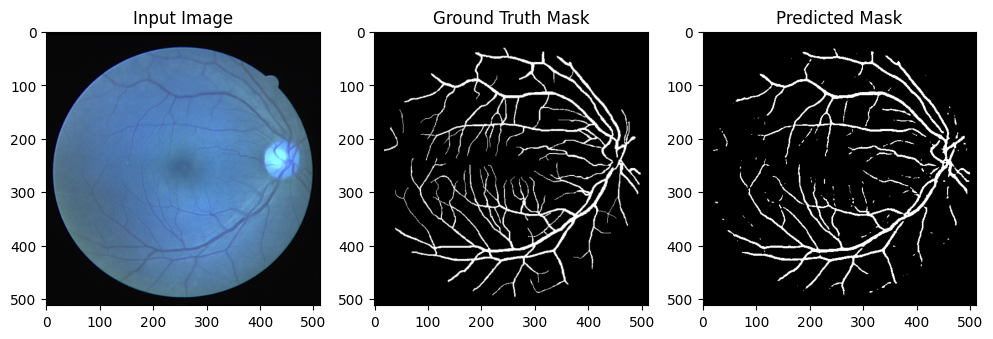

Image 19: pred min=0.0225, max=1.0000


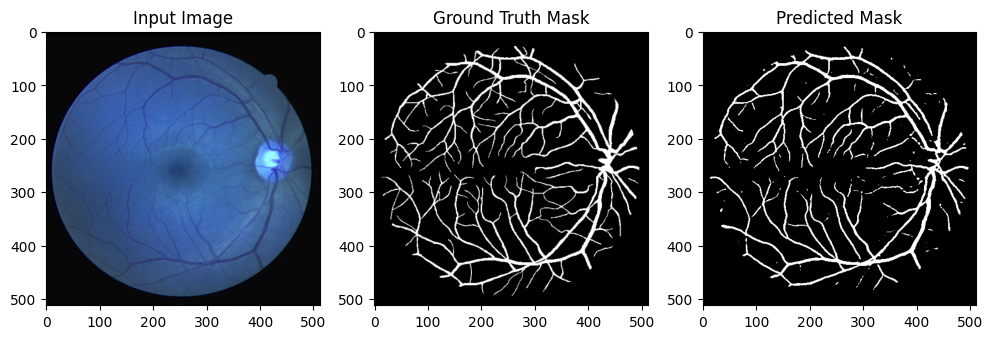

Image 20: pred min=0.0337, max=0.9999


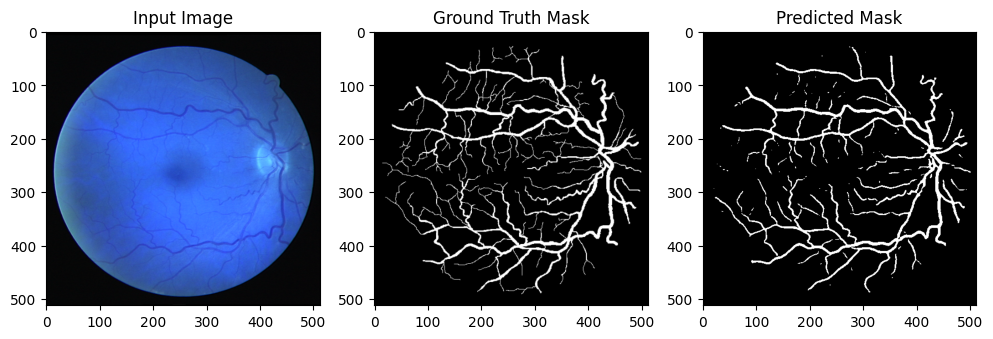

In [ ]:
import matplotlib.pyplot as plt
import torch

# --- Load trained model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet().to(device)
model.load_state_dict(torch.load("files/checkpoint.pth", map_location=device))
model.eval()

# --- Combine train + valid datasets ---
all_dataset = DriveDataset(train_x + valid_x, train_y + valid_y)

# --- Predict and visualize ---
with torch.no_grad():
    for i in range(len(all_dataset)):
        img, mask = all_dataset[i]              # tensors
        img_batch = img.unsqueeze(0).to(device) # add batch dimension

        # Model prediction
        pred = model(img_batch)
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()

        # Optional: check prediction range
        print(f"Image {i+1}: pred min={pred.min():.4f}, max={pred.max():.4f}")

        # Plot input, mask, and predicted mask
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img.permute(1,2,0).numpy(), cmap='gray')
        plt.title("Input Image")

        plt.subplot(1,3,2)
        plt.imshow(mask.squeeze().numpy(), cmap='gray')
        plt.title("Ground Truth Mask")

        plt.subplot(1,3,3)
        # Threshold at 0.5 (adjust if predictions are low)
        plt.imshow(pred > 0.5, cmap='gray')
        plt.title("Predicted Mask")
        plt.show()
